
# Programa Ejemplo para Realizar Aprendizaje Supervisado

## Etapa 1: Entendimiento de los datos
Antes de comenzar incluso a preprocesar los datos, debemos conocer las características del conjunto de datos que tenemos.

Como mínimo debemos saber:
-  Cuántos registros hay?
-  Cuantos atributos tiene cada registro?
-  De qué tipo son los atributos?

Además:
-  Obtener una medida de centralidad para cada atributo
-  Obtener una medida de dispersión o desviación para los atributos que ésto tenga sentido
-  Calcular la matriz de correlación de los atributos de entrada para identificar atributos redundantes

Como paso previo al preprocesamiento de los datos, debemos:
-  Detectar si hay datos faltantes (determinar en qué columnas y cuantos datos faltan en un mismo registro)
-  Detectar si hay datos atípicos
-  Detectar si hay desbalance entre clases

Notar que en esta etapa no hacemos ninguna modificación sobre los datos, sólo estamos conociéndolos a fondo para saber con qué material contamos para trabajar.


In [44]:
# Carga de librerías y lectura del archivo que contiene los datos

import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
data = pd.read_csv(url, header=None, na_values=" ?")

# Se etiquetan las columnas para poder interpretar más fácilmente los datos.
# Cada fila es un ejemplo, cada columna un atributo.
# La columna llamada C es el atributo a predecir
data.columns = ['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status', 'Occupation',
              'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss', 'Hpw', 'Country', 'C']
data.head()

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hpw,Country,C
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [45]:
#Cuál es el número de registros?
#Cuál es el número de atributos?

shape = data.shape
shape

(32561, 15)

In [46]:
#Cual es el tipo de los atributos?
data.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education-num      int64
Marital-status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-gain       int64
Capital-loss       int64
Hpw                int64
Country           object
C                 object
dtype: object

In [47]:
#Medida de centralidad y desviación para atributos numéricos:
data.describe()

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hpw
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


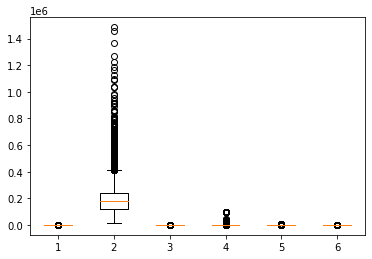

In [48]:
# Diagrama de cajas y bigotes para atributos numéricos
# Permite identificar la existencia de datos atípicos

plt.boxplot((data['Age'],data['Fnlwgt'],data['Education-num'],data['Capital-gain'],data['Capital-loss'], data['Hpw']))
plt.show()

In [49]:
#Medida de centralidad para atributos categóricos:
data.mode()

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hpw,Country,C
0,36.0,Private,123011,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
1,NaN,NaN,164190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,203488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Correlación entre los atributos de entrada numéricos
# Permite detectar si hay atributos redundantes (correlación mayor a 0.85 o menor a -0.85)
data.corr()

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hpw
Age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
Fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
Education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
Capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
Capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
Hpw,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


In [51]:
# Cual es el máximo de datos faltantes en un mismo registro?
# Si hay registros a los que les faltan muchos valores, es mejor eliminarlos.
max(data.isnull().sum(axis=1))

3

In [52]:
#Cuantos datos faltantes hay por cada atributo?
data.isnull().sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education-num        0
Marital-status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital-gain         0
Capital-loss         0
Hpw                  0
Country            583
C                    0
dtype: int64

In [53]:
#Cuantos registros hay por cada clase? es decir, por cada valor del atributo de salida?

print(data['C'].value_counts())

 <=50K    24720
 >50K      7841
Name: C, dtype: int64


## Etapa 2: Preparación de los datos
De acuerdo a lo observado en la etapa 1, se define una secuencia de actividades que modifican los datos para eliminar las situaciones que puedan ser causa de fallo o deficiencia en el proceso de aprendizaje. En este caso se van a realizar las siguientes actividades:


1.   Completar los datos faltantes utilizando la media para atributos numéricos y la moda para atributos categóricos.
2.   Convertir los atributos categóricos a escala numérica.
3.   Normalizar los valores de algunos los atributos.
4.   Balancear las clases eliminando registros de la clase mayoritaria.






In [54]:
# Se reemplazan los datos faltantes (NaN) por la moda de cada atributo.
data["Workclass"].fillna("Private", inplace = True)
data["Occupation"].fillna("Prof-specialty", inplace = True)
data["Country"].fillna("United-States", inplace = True)
data.head()

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hpw,Country,C
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [55]:
from sklearn.preprocessing import LabelEncoder 

# Se convierten los atributos categóricos a valores numéricos
labelencoder= LabelEncoder() 
data['Country'] = labelencoder.fit_transform(data['Country'])
data['Occupation'] = labelencoder.fit_transform(data['Occupation'])
data['Workclass'] = labelencoder.fit_transform(data['Workclass'])
data['Education'] = labelencoder.fit_transform(data['Education'])
data['Marital-status'] = labelencoder.fit_transform(data['Marital-status'])
data['Relationship'] = labelencoder.fit_transform(data['Relationship'])
data['Race'] = labelencoder.fit_transform(data['Race'])
data['Sex'] = labelencoder.fit_transform(data['Sex'])
data['C'] = labelencoder.fit_transform(data['C'])
data.head()

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hpw,Country,C
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0


In [56]:
from sklearn import preprocessing

# Se normalizan los tres atributos seleccionados
data['Fnlwgt'] = preprocessing.scale(data['Fnlwgt'])
data['Capital-gain'] = preprocessing.scale(data['Capital-gain'])
data['Capital-loss'] = preprocessing.scale(data['Capital-loss'])
data.head()

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hpw,Country,C
0,39,6,-1.063611,9,13,4,0,1,4,1,0.148453,-0.21666,40,38,0
1,50,5,-1.008707,9,13,2,3,0,4,1,-0.145920,-0.21666,13,38,0
2,38,3,0.245079,11,9,0,5,1,4,1,-0.145920,-0.21666,40,38,0
3,53,3,0.425801,1,7,2,5,0,2,1,-0.145920,-0.21666,40,38,0
4,28,3,1.408176,9,13,2,9,5,2,0,-0.145920,-0.21666,40,4,0


In [57]:
# Se hace balanceo de clases eliminando ejemplos de la clase mayoritaria
g = data.groupby('C')
dataBal = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
dataBal

Age  Workclass    Fnlwgt  Education  ...  Capital-loss  Hpw  Country  C
C                                            ...                               
0 0      21          8  0.001039          7  ...      -0.21666   55       38  0
  1      51          3 -0.500864         11  ...      -0.21666   40       38  0
  2      21          3  0.106062         15  ...      -0.21666   20       38  0
  3      25          3 -0.827283          9  ...      -0.21666   40       38  0
  4      58          3  1.664949         15  ...      -0.21666   40       25  0
...     ...        ...       ...        ...  ...           ...  ...      ... ..
1 7836   41          3 -0.846317         11  ...      -0.21666   38       38  1
  7837   49          3 -1.205441          9  ...      -0.21666   40       38  1
  7838   47          4 -0.031913         14  ...      -0.21666   60       38  1
  7839   50          1 -0.528813          9  ...      -0.21666   40       38  1
  7840   50          3  0.455617         12  ...      -0.21666   50       38  1

[15682 rows x 15 columns]

In [58]:
# Se verifica que haya quedado el mismo número de registros por cada clase
print(dataBal['C'].value_counts())

1    7841
0    7841
Name: C, dtype: int64


## Etapa 3: Modelado
En esta etapa se van a utilizar los datos para realizar aprendizaje del atributo C a partir de los valores de los demás atributos. Es decir, se va a predecir si una persona tiene ingresos superiores o inferiores a 50K dolares. Las actividades a realizar son:
1.   Dividir el conjunto de datos en conjuntos de entrenamiento y test.
2.   Realizar el entrenamiento del modelo de regresión logística utilizando para ello el conjunto de entrenamiento.
3.   Aplicar el modelo construido a los datos del conjunto de test.
4.   Cálculo de una métrica de desempeño para evaluar la calidad del modelo en sus prediciones sobre el conjunto de test.

In [67]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataBal.drop('C', axis=1), dataBal.C, test_size=0.30)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(10977, 14) (10977,)
(4705, 14) (4705,)


In [68]:
# Entrenamiento del modelo de clasificación por regresión logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logisticRegr = LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01)
logisticRegr.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False)

In [69]:
# Aplicación del modelo construido a los datos de test
predictions = logisticRegr.predict(X_test)
predictions

array([1, 0, 0, ..., 0, 1, 0])

In [71]:
# Cálculo del accuracy para evaluar el desempeño del modelo sobre los datos de test
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions)

0.7655685441020191

# Fin del programa